# Interrupted time-series analysis of the evaluation metrics in the intervention and control group

## Aims

- Explore the characteristics of the time-series of the main evaluation metrics (in terms of trends and seasonality) in the intervention and control group

- Interrupted time-series analysis: compare the whole pre-test segment (so A0 to A2, i.e. 11-Oct to 19-Nov) and whole post-test segment (so B1-B2, i.e. 21-Nov to 19-Dec) using a univariate interrupted time-series analysis (ITS)

- Use the control time-series to run a controlled interrupted time-series analysis (CITS) to try to disentangle the effects of the intervention from any effect due to external confounding factors (see section on Control Time-Series below for more info).

IMPORTANT: the 20th Nov is the day where the related-link generator switched from unweighted to weighted and will be excluded from the analysis as the shift is not clear cut. 



### Background

**Intervention time-series**

With "intervention time-series", we mean the time-series of data that is impacted by the intervention (i.e., the switch from unweighted to weighted automatically-generated related links).  

As main metrics, we are investigating:
- (1) the proportion of day visitors who clicked on a RL at least once
- (2) the proportion of day visitors who, having clicked on a RL, click again on at least another RL that day
 
The denominator of (1) is the total number of visitors who, on a given day, visited at least one page displaying node2vec related links; the denominator for (2) is the total number of visitors in (1).

Rationale:
When a user is on a page, many elements compete for their attention. Thus, (1) reflects the fact that (one of) our related links provided the strongest/most promising clue (in information scent theory) and won their attention.
(2) represents a type of "trust mechanism" our related links managed to build trust with the visitor: they clicked on a RL, and then they clicked again on more RLs, suggesting that the first "RL experience" was positive. The metric captures a kind of "repeated-purchaser" behaviour.



**Control time-series**

With "control time-series", we mean a time-series of data that, to our best knowledge:

- spans the same time period as the intervention time-series 
- is not affected by the intervention. 
- shares confounders with the intervention time-series (i.e., same confounders should have the same effects on both control and intervention time series).

These characterictis of the control time-series will allow us to pin down the effect of the intervention (i.e., shift from unweighted to weighted related links) beyond the "whatever else" which may also have affected the intervention time series (e.g., other experiments, like from Explore team, or external factors, like the increase in single-page visits due to covid to report flow tests or check travel info) .

As controls that meet the above requirements, we chose:
- the proportion of day visitors who clicked on a manually-cuarted related link
- the proportion of day visitors who, having clicked on a manually-cuarted related link, go on to click on at least another one (repeated-clickers);
importantly, we restricted the sample to only those visitors who, on a given day, only visited mainstream pages with manually curated related links (and nothing else). This, to ensure the user behaviour captured by these time series was not affected by our intervention.


The time-series data were created by:

- [**intervention**] the [`notebooks/2021_tests/gather_metrics.sql`](https://github.com/alphagov/govuk_ab_analysis/blob/master/notebooks/2021_tests/gather_metrics.sql`) for the time period 11-Oct-2021 to 19-Dec-2021 (covering both A (unwighted) and B (weighted) segments) with data saved in the `govuk-bigquery-analytics.datascience.related_links_20211011_20211219_intervention` BigQuery table.

- [**control**] the [`notebooks/2021_tests/gather_metrics_control.sql`](https://github.com/alphagov/govuk_ab_analysis/blob/master/notebooks/2021_tests/gather_metrics_control.sql`) for the same time period 11-Oct-2021 to 19-Dec-2021 with data saved in the `govuk-bigquery-analytics.datascience.control_manual_links_20211011_20211219_data` BigQuery table.


**IMPORTANT**: This notebook uses an R kernel.

### How to setup Jupyter Notebook for R

These instructions assume that you already have a working Python environment for your local repository of this project, and Jupyter Notebook already installed in that environment that you can execute from your Terminal.

1. Install R 

   If not already installed, see https://cloud.r-project.org/index.html
   

2. Install R kernel for Jupyter Notebook

    In your Terminal (note: not in RStudio, not in the R GUI):
    
    - launch R by entering `R` on the command line.

    - You should now be using R from your Terminal. Thus, run:
    ```
    install.packages('IRkernel')
    IRkernel::installspec()
    ```

    Done! You can now quit R by entering `q()`.

If you now launch Jupyter Notebook, you'll have the option to choose `R` as kernel.


### Requirements

You need to have service account credentials to the BigQuery `govuk-bigquery-analytics.datascience` dataset.

## Setting things up

In [ ]:
# Install packages, if they aren't already available.
# This can take a minute or two.
packages <- c("bigrquery", "tidyverse", "plotly", "gridExtra", 
              "tsibble", "lubridate", "feasts", "DT", "TTR", "lmtest", "Epi", "tsModel", "sandwich", "lmtest")
install.packages(setdiff(packages, rownames(installed.packages())), quiet = TRUE) 

In [ ]:
for(pckg in packages){
    suppressPackageStartupMessages(library(pckg, character.only = TRUE))
}

In [ ]:
#Authenticate
#/path/to/your/service-account.json
bq_auth(path = "/Users/alessiatosi/Secrets/govuk-bigquery-analytics-service-credentials.json")  

In [ ]:
# Make plots wider 
options(repr.plot.width=15, repr.plot.height=8)

In [ ]:
# create custom plotting theme
theme_custom <- theme(plot.title = element_text(face = "bold", hjust = 0.5, size=18),
                      plot.subtitle = element_text(size=14),
                      axis.text.y = element_text(colour = 'black', size = 12), 
                      axis.title.y = element_text(size = 16, hjust = 0.5, vjust = 0.2),
                      axis.text.x = element_text(colour = 'black', size = 12), 
                      axis.title.x = element_text(size = 16, hjust = 0.5, vjust = 0.2),
                      panel.background = element_blank(),
                      axis.line = element_line(colour = "black"),
                      legend.position = "bottom",
                      legend.direction = "horizontal")

## Get the data

In [ ]:
#billing <- "govuk-xgov" # replace this with your project ID 
project = "govuk-bigquery-analytics"

sql_intervention <- "SELECT * FROM `govuk-bigquery-analytics.datascience.related_links_20211011_20211219_intervention`"
sql_control <- "SELECT * FROM `govuk-bigquery-analytics.datascience.control_manual_links_20211011_20211219_data`"

tb <- bq_table_download(bq_project_query(project, sql_intervention))
tb_control <- bq_table_download(bq_project_query(project, sql_control))

## Data pre-processing

In [ ]:
# cast date as a date type variable

tb$date <- as.Date(strptime(tb$date, "%Y%m%d"))
tb_control$date <- as.Date(strptime(tb_control$date, "%Y%m%d"))

In [ ]:
tb <- tb %>% 
    arrange(date)

tb_control <- tb_control %>% 
    arrange(date)

In [ ]:
# glimpse
head(tb)

## Plotting the time series of data

Here we will plotting the time series of data for all the metrics. Later in the notebook we will explore seasonality and trends in the time series of the two main evaluation metrics:
- Proportion of visitors who click a related link (RL) at least once
- Proportion of repeated-clicker visitors (those that, having click on a RL, click on others)

In [ ]:
plot_timeseries <- function(data, 
                            ts_var="", 
                            title="", 
                            x_title="", 
                            subtitle = "Intervention time series (visited at least one page with node2vec related links)"){
    #'@param data (data.frame) : dataset  
    #'@param ts_var (character string) : name of the variable containing the time-series data
    #'@param title (character string) : plot title
    #'@param x_title (character string) : x-axis title
    #'@return time-series plot
    
    if(!"date" %in% colnames(data)) stop(paste0("column `date` is missing from dataset"))
    
    sym_ts_var <- dplyr::sym(ts_var)
    
    data %>% 
    ggplot2::ggplot(., aes(date, !!sym_ts_var)) +
    geom_point(size=2) +
    geom_line(size=1) +
    #geom_smooth(method="lm", colour="blue") +
    geom_smooth(method = "loess", formula=y~x, colour="purple", se=TRUE) +
    geom_vline(aes(xintercept = as.Date("20211025", "%Y%m%d")), col="blue", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211110", "%Y%m%d")), col="darkgreen", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211111", "%Y%m%d")), col="blue", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211120", "%Y%m%d")), col="red", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211211", "%Y%m%d")), col="red", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211213", "%Y%m%d")), col="darkgreen", linetype=2) +
    geom_text(aes(x=as.Date("20211025", "%Y%m%d"), y=0, label="25 Oct 2021 unweighted"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="blue") +
    geom_text(aes(x=as.Date("20211110", "%Y%m%d"), y=0, label="10 Nov 2021 menu bar v2"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="darkgreen") +
    geom_text(aes(x=as.Date("20211111", "%Y%m%d"), y=0, label="11 Nov 2021 unweighted"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="blue") +
    geom_text(aes(x=as.Date("20211120", "%Y%m%d"), y=0, label="20 Nov 2021 weighted"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="red") +
    geom_text(aes(x=as.Date("20211211", "%Y%m%d"), y=0, label="12 Dec 2021 weighted"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="red") +
    geom_text(aes(x=as.Date("20211213", "%Y%m%d"), y=0, label="13 Dec 2021 new homepage"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="darkgreen") +
    labs(
        title = title,
        subtitle = subtitle) +
    ylab(x_title) +
    theme_custom
    }

### Intervention

#### Main metrics of evaluation

In [ ]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_used_rl",
               title="Rate of visitors who clicked on at least 1 related link",
               x_title="Rate of visitors")

There seems to be a decline throughout the whole time series which become more pronounced as the time series unfolds. However, this does not seem to coincide with the shift to weighted related links. 
We can also observe day-of-the week seasonality, with lower values consistently obeserved for Saturday and Sunday data.

Let's check the number to see whether the decline may be explained by an increase in the denominator (so in the number of day visitors who visit at least one page with node2vec related links) rather than a decrease in the numerator (so the number of those who click on a related link). This may be the case if, for instance, external circumstance would bring visitors to come and look at one page only. 

In [ ]:
plot_timeseries(data=tb,
               ts_var="visitors_that_clicked_rl",
               title="Number of visitors who clicked on at least 1 related link",
               x_title="Number of visitors")

It looks like that may partially explain the downward trend we observe in the previous graph of the proportion of day visitors.

In [ ]:
head(tb)

In [ ]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_returning_to_rl",
               title="Rate of repeated-clicker visitors (of those who clicked on one RL)",
               x_title="Rate of visitors")

Here the trend is less pronounced. We can still observe some weekly seasonality.  

#### Other potential behaviour of interest

In [ ]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_that_clicked_navigation",
               title="Rate of visitors who clicked on a navigation element",
               x_title="Rate of visitors")

In [ ]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_2_or_more_rl",
               title="Rate of visitors who clicked 2 or more related links",
               x_title="Rate of visitors")

### Control

#### Main control metrics

In [ ]:
plot_timeseries(data=tb_control,
               ts_var="pc_visitors_used_rl",
               title="Rate of visitors who clicked on at least 1 manually-curated related links",
               x_title="Rate of visitors",
               subtitle = "Control time series (visited only manually-curated related-links pages)")

Here as well we can observe a strong downward trend over time in the proportion of day visitors who clicked on at least one manually-curated realted links. 
Some weekly seasonality here as well, albet less clear cut.

In [ ]:
plot_timeseries(data=tb_control,
               ts_var="pc_visitors_returning_to_rl",
               title="Rate of repeated-clicker visitors on a given day (manually-curated related links)",
               x_title="Rate of visitors",
               subtitle = "Control time series (visited only manually-curated related-links pages)")

Hard to see any clear trend here. No clear sign of weekly seasonality either.

## Trends, seasonality and stationarity

- **Trend**: whether and when there is an overall increasing or decreasing pattern in our observations over time
- **Seasonality**: whether and when there are repeating patterns in the series at fixed and known periods (e.g., weekly)
- **Stationarity**: when a time-series has constant mean, variance and covariance over time
Put another way, a time-series is **stationary** when it has no trend nor seasonality, and has constant variance over time. Typically, this will mean when you plot values over time, it will be roughly horizontal (though some cyclic behaviour is possible) and have constant variance.

- **Remainder/random noise**: leftover of original time-series after trend and seasonality are removed
- **Autocorrelation**: the strength of the relationship between a variable and its observations at prior time-periods
The **autocorrelation function** is a plot of a **stationary** time-series with its lags (meaning its observations at prior time-periods). It can be used to obtain the order of a **moving-average model**, *q*. It will be the first lag at which the **autocorrelation** value passes the upper 95% **confidence interval**, as indicated by the blue dotted line in the corresponding **ACF** plot.

- **Partial autocorrelation**: the strength of the relationship between an observation in a time-series with its observations at prior time-peridos, with the relationships of intervening observations removed. **Partial autocorrelation** is different to **autocorrelation** because the latter is comprised of both *direct* and *indirect* correlations, whereas the former removes these *indirect* correlations. It can be used to obtain the order of an auto-regressive model, *p*.^[Indirect correlations are a linear function of the correlation of the observation, with observations at intervening time periods.]

Here we'll explore **trend** and **seasoanlity** to help identify whether our key metric values have evolved over time. We will make large use of the "Seasonal and Trend decomposition using Loess" (LST) method to decompose the time series and identify trends and seasonality patterns. For more info, see https://otexts.com/fpp2/stl.html. 

Whereas we will use the **ACF** (auto-correlation function) on the residuals of the time series (so on the time series made stationary after removing trend and seasonality) to identify any remaining auto-correlation patterns in the data.


In [ ]:
# convert to time-series object
tb <- tb %>%
    tsibble::as_tsibble(index = date)

tb_control <- tb_control %>%
    tsibble::as_tsibble(index = date)

In [ ]:
plot_SLT <- function(data, ts_var="", title_ts_var=""){
    #'@param data (data.frame) : dataset  
    #'@param ts_var (character string) : name of the variable containing the time-series data
    #'@param title_ts_var (character string) : Plain English description of time-series variable
    #'@return time-series plot
    
    if(!"date" %in% colnames(data)) stop(paste0("column `date` is missing from dataset"))
    
    sym_ts_var <- dplyr::sym(ts_var)
    
    decomp <- data %>% model(STL(!!sym_ts_var)) %>% components()
    
    p1 <- decomp %>% autoplot()
    
    p2 <- decomp %>% 
        select(remainder) %>% 
        acf(main = "ACF of residuals (trend and seasonality removed)")
    
    list(p2, p1)
    }

In [ ]:
# Show what a decomposed time series look like
tb %>% model(STL(pc_visitors_used_rl)) %>% components() %>% head()

### Intervention

#### Rate of visitors who click RL at least once

In [ ]:
plot_SLT(tb, "pc_visitors_used_rl", "Rate of visitors who clicked RL at least once")

#### Rate of repeated-clicker visitors

In [ ]:
plot_SLT(tb, "pc_visitors_returning_to_rl", 
         "Rate of visitors who clicked on more RLs after having clicked on one")

#### Rate of visitors who clicked on a navigation element while on a RL page

In [ ]:
plot_SLT(tb, "pc_visitors_that_clicked_navigation", 
         "Rate of visitors who clicked on a navigation element")

### Control

#### Rate of visitors who click RL at least once

In [ ]:
plot_SLT(tb_control, "pc_visitors_used_rl", "Rate of visitors who clicked RL at least once")

#### Rate of repeated-clicker visitors

In [ ]:
plot_SLT(tb_control, "pc_visitors_returning_to_rl", 
         "Rate of visitors who clicked on more RLs after having clicked on one")

### Conclusions

The time series of our two main metrics of evaluation display both weekly seasonality and some downward not-fully linear trends that we will try to account for when modelling the time-series as part of the interrupted time series analysis.

There are some signs of weak remaining auto-correlation on the de-trended stationary time series which we will see whether problematic when modelling the data. 

## Interrupted and Controlled Interrupted Time Series Analysis

### Comparing whole intervention time-series (pre-/post segments) and control

### Data preparation

In [ ]:
# join the two time series by date
ts <- tb %>% inner_join(tb_control, by="date")

Too many variables, let's only retain the relevant for the analyses.

In [ ]:
names(ts)

In [ ]:
ts <- ts[, c('date', 
             'visitors.x',
             'visitors.y', 
             'visitors_that_clicked_rl.x',
             'visitors_that_clicked_rl.y',
             'visitors_2_or_more_rl.x',
             'visitors_2_or_more_rl.y',
             'pc_visitors_used_rl.x',
             'pc_visitors_used_rl.y',
             'pc_visitors_returning_to_rl.x',
             'pc_visitors_returning_to_rl.y')]

In [ ]:
ts_long <- gather(ts, metric, value, c('visitors.x',
                                       'visitors.y', 
                                       'visitors_that_clicked_rl.x',
                                       'visitors_that_clicked_rl.y',
                                       'visitors_2_or_more_rl.x',
                                       'visitors_2_or_more_rl.y',
                                       'pc_visitors_used_rl.x',
                                       'pc_visitors_used_rl.y',
                                       'pc_visitors_returning_to_rl.x',
                                       'pc_visitors_returning_to_rl.y'), 
                   factor_key=FALSE)



In [ ]:
tail(ts_long)

In [ ]:
ts_long <- ts_long %>% 
    separate(metric, c("metric", "time_series"), sep = "\\.") %>% 
    mutate(time_series = ifelse(time_series == "x", "intervention", "control"))   

In [ ]:
head(ts_long)


Here we are replotting the time series of data, this time intervention and control together in the same plot to facilitate comaparisons.

In [ ]:
plot_multiple_timeseries <- function(data, 
                            ts_var="", 
                            group_var="",
                            title="", 
                            x_title="", 
                            subtitle = "Control-group time series (only visited pages with manually-curated links )"){
    #'@param data (data.frame) : dataset  
    #'@param ts_var (character string) : name of the variable containing the time-series data
    #'@param title (character string) : plot title
    #'@param x_title (character string) : x-axis title
    #'@return time-series plot
    
    if(!"date" %in% colnames(data)) stop(paste0("column `date` is missing from dataset"))
    
    sym_ts_var <- dplyr::sym(ts_var)
    sym_group_var <- dplyr::sym(group_var)
    
    data %>% 
    ggplot2::ggplot(., aes(date, !!sym_ts_var, group=!!sym_group_var, colour=!!sym_group_var)) +
    geom_point(size=2) +
    geom_line(size=1) +
    #geom_smooth(method="lm", colour="blue") +
    geom_smooth(method = "loess", formula=y~x, colour="purple", se=TRUE) +
    geom_vline(aes(xintercept = as.Date("20211025", "%Y%m%d")), col="blue", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211110", "%Y%m%d")), col="darkgreen", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211111", "%Y%m%d")), col="blue", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211120", "%Y%m%d")), col="red", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211211", "%Y%m%d")), col="red", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211213", "%Y%m%d")), col="darkgreen", linetype=2) +
    geom_text(aes(x=as.Date("20211025", "%Y%m%d"), y=0, label="25 Oct 2021 unweighted"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="blue") +
    geom_text(aes(x=as.Date("20211110", "%Y%m%d"), y=0, label="10 Nov 2021 menu bar v2"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="darkgreen") +
    geom_text(aes(x=as.Date("20211111", "%Y%m%d"), y=0, label="11 Nov 2021 unweighted"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="blue") +
    geom_text(aes(x=as.Date("20211120", "%Y%m%d"), y=0, label="20 Nov 2021 weighted"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="red") +
    geom_text(aes(x=as.Date("20211211", "%Y%m%d"), y=0, label="12 Dec 2021 weighted"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="red") +
    geom_text(aes(x=as.Date("20211213", "%Y%m%d"), y=0, label="13 Dec 2021 new homepage"), 
              size=4, angle=90, vjust=-0.4, hjust=0, color="darkgreen") +
    labs(
        title = title,
        subtitle = subtitle) +
    ylab(x_title) +
    theme_custom
    }

In [ ]:
ts_long %>%
    filter(metric=="pc_visitors_used_rl") %>%
    plot_multiple_timeseries(data=., 
                         ts_var="value", 
                         group_var="time_series",
                         title="Rate of day visitors who clicked on at least 1 related-link", 
                         x_title="Rate of day visitors", 
                         subtitle = "Intervention and control time series")

In [ ]:
ts_long %>%
    filter(metric=="pc_visitors_returning_to_rl") %>%
    plot_multiple_timeseries(data=., 
                         ts_var="value", 
                         group_var="time_series",
                         title="Rate of daily repeated-clicker visitors", 
                         x_title="Rate of daily visitors", 
                         subtitle = "Intervention and control time series")

### Possible concurring cause

Here we will check whether an increase in single page visits, perhaps linked to an increased needs to find coronavirus information like reporting lateral flow test or checking travel advice, may explain the decrease in proportions of users who click on related links.

Single-page visiting visitors, in fact, would "inflate" the denominator in our proportions.

In [ ]:
sql_singlepage_sessions <- "SELECT * FROM `govuk-bigquery-analytics.datascience.singlepage_dayvisitors_20211011_20211219`"

tb_ss <- bq_table_download(bq_project_query(project, sql_singlepage_sessions))

In [ ]:
# cast date as a date type variable
tb_ss$date <- as.Date(strptime(tb_ss$date, "%Y%m%d"))

# filter for the single-page session data
tb_ss <- tb_ss %>%
    filter(single_pagehit_session == TRUE)


In [ ]:
plot_timeseries(data=tb_ss, 
                ts_var="proportion", 
                x_title="Rate of single-page day-visitors", 
                title="Rate of visitors who only visited one page on given day",
               subtitle="")

In [ ]:
plot_timeseries(data=tb_ss, 
                ts_var="frequency",
                x_title="Number of single-page day-visitors", 
                title="Number of visitors who only visited one page on given day",
               subtitle="")

There seems to be an upward trend, especially in the number of day visitors who only visited one page. However, unless we do further investigation, we cannot be sure why this is the case and whether this is impacting either of our metrics.

## Analysis

We refer you to the Google doc for a brief introduction to the Interrupted Time Series approach, what the model looks like, interpretation of coefficients and required data preparation.

We will use a stricter significance level (false positive rate) of `alpha = 0.01`. 

In [ ]:
ts_long <- ts_long %>%
    mutate(day_of_week = weekdays(date))

In [ ]:
# let's remove the muddled 20th Nov data 
# NOTE: also tempted to remove the 21st Nov as well, since, given that it is a Sunday. 
# But hopefully if we model the seasonality correctly that shoudn't biased the results for the level parameter
ts_long <- ts_long %>% filter(date != as.Date("2021-11-20"))

### Proportion of visitors who clicked on at least one related link

In [ ]:
clicks_ts <- ts_long %>% filter(metric=='pc_visitors_used_rl') 

Create new variables:
- **Time**: time variable capturing time passed from start of the intervention
- **Intervention**: dummy variable signalling before (0) and after (1) weighted related-links were introduced
- **TimeSince**: variable capturing time passed since intervention (introduction of weighted related links) occured

In [ ]:
clicks_ts <- clicks_ts %>%
    group_by(time_series) %>%
    mutate(Time = row_number()) %>%
    mutate(Intervention = ifelse(date <= as.Date("2021-11-20"), 0, 1))

In [ ]:
# how many data points after intervention took place?
table(clicks_ts[clicks_ts$time_series=="intervention",]$Intervention)

In [ ]:
n_points_before <- as.numeric(table(clicks_ts[clicks_ts$time_series=="intervention",]$Intervention)["0"])
n_points_after <- as.numeric(table(clicks_ts[clicks_ts$time_series=="intervention",]$Intervention)["1"])

In [ ]:
clicks_ts$TimeSince <- 0
clicks_ts[clicks_ts$time_series=="intervention",]$TimeSince <- c(rep(0, n_points_before), rep(1:n_points_after))
clicks_ts[clicks_ts$time_series=="control",]$TimeSince <- c(rep(0, n_points_before), rep(1:n_points_after))

In [ ]:
# Let's check around the date (20th Nov) when the intervention took place
clicks_ts[37:45,]

In [ ]:
# everything looks as it should - GOOD
# also notice the absence of Nov-20th which we removed

### Interrputed time-series analysis (ITS)

We'll start with the single (intervention) time-seies, comparing pre- and post- intervention. So let's extract that data 

In [ ]:
# intervention time-series only data
clicks_its <- clicks_ts[clicks_ts$time_series=="intervention",]

In [ ]:
head(clicks_its)

**The following is for visualisation purpose only.**

We will replot the data, displaying the predicted counterfactual and observed valued for the period after the intervention took place (i.e., from 21st Nov onwards).
OSL makes it easier to see trends. We will model the data more thoroughly (accounting for seasonality and autocorrelation etc...) later - and those will be the statistical findings we will report. 

In [ ]:
# Only raw data 
# treating the time series of proportion
plot(clicks_its$Time, 
    clicks_its$value,
      bty="n",
      col = gray(0.3,0.5), pch=19,
      ylim = c(0, 0.04), 
      xlim = c(0,72),
      main = "Proportion of visitors who clicked on at least 1 related link",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Proportion of visitors")
mtext(side = 3, line = 0.25, at = 1, adj = -1.6, "(node2vec-generated related links only)")

# Line marking the interruption
abline( v=n_points_before+1, col="firebrick", lty=2 )
text( n_points_before+1, 0, "Start of Weighted related links", col="firebrick", cex=1.3, pos=4 )


In [ ]:
# Regression line
reg_clicks <- lm( value ~ Time + Intervention + TimeSince, data=clicks_its )

# Estimate all predicted values of Y (we just use our original dataset)
pred1 <- predict(reg_clicks, clicks_its) 

# Counterfactual
# (1) create a new dataset where Intervention and TimeSince Treatment are equal to 0 
# (as if the intervention did not happen)
datanew <- as.data.frame(cbind(Time = rep(1 : length(clicks_its$Time)), 
                               Intervention = rep(0), 
                               TimeSince = rep(0))) 
# (2) predict the counterfactuals
pred2 <- predict(reg_clicks, datanew) 

# Plot
plot(clicks_its$Time, 
    clicks_its$value,
      bty="n",
      col = gray(0.3,0.5), pch=19,
      ylim = c(0, 0.04), 
      xlim = c(0,72),
      main = "Proportion of visitors who clicked on at least 1 related link",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Proportion of visitors")
mtext(side = 3, line = 0.25, at = 1, adj = -1.6, "(node2vec-generated related links only)")

# Add the prediected regression lines for the observed data (for befoe and after the intervention)
lines( 1:(n_points_before), pred1[1:(n_points_before)], col="dodgerblue4", lwd = 3 )
lines( (n_points_before+1):70, pred1[(n_points_before+1):70], col="dodgerblue4", lwd = 3 )
# Add the counterfactual line
lines( (n_points_before+1):70, pred2[(n_points_before+1):70], col="darkorange2", lwd = 3, lty = 5 ) 

text(45, 0.015, labels = "Predicted values", pos = 4, cex = 1.3, col = "dodgerblue3")
text(50, 0.025, labels = "Counterfactual", pos = 4, cex = 1.3, col = "darkorange2")

# Line marking the interruption
abline( v=(n_points_before+1), col="firebrick",lwd = 2, lty=2 )
text( (n_points_before+1), 0, "Start of weighted related links", col="firebrick", cex=1.3, pos=4 )


#### Poisson approach

There are different ways we can analyse this data. 

One way we can think of the data-generation process is as a Poisson process capturing the number of day visitors that clicked on at least a node2vec related links at a rate `lambda` per day.  

The rate can be obtain, on each day, as: `number of visitors that clicked rl / number of visitors * 10^5`
(so that would be the rate per 100,000 visitors).

Remember that the denominator is not all visitors to gov.uk but those visitors who visited at least one page desplaying node2vec-generated related links. 

We can then analyse this data using a Poisson generalised linear model (https://en.wikipedia.org/wiki/Poisson_regression) with an offset variable capturing the log-denominator (https://www.theanalysisfactor.com/the-exposure-variable-in-poission-regression-models/), and regressing incidence/rate on time and the intervention indicator, while accouting for overdispersion, seasonality and autocorrelation effects.

This is what we do here. 

However, it is well established in statistics, that the Normal distribution is a suitable approximation of the Poisson distribution when `lambda` (the rate) is high (say, lambda > 100).
As it is the case here. So we will also re-do the analysis treating the process as a stochastic Normal process to show that the results (using an OLS regression) will be equivalent and stick to the OLS approach for remaining CTIS analysis as it simplifies the modelling/approach. 



##### Data preparation

In [ ]:
unique(ts_long$metric)

In [ ]:
clicks_ts <- ts_long %>% filter(metric %in% c('visitors', 'visitors_that_clicked_rl')) 

clicks_ts <- clicks_ts %>%
    group_by(time_series, metric) %>%
    mutate(Time = row_number()) %>%
    mutate(Intervention = ifelse(date <= as.Date("2021-11-20"), 0, 1))

In [ ]:
# check
table(clicks_ts[clicks_ts$metric == "visitors",]$time_series)
table(clicks_ts[clicks_ts$metric == "visitors_that_clicked_rl",]$time_series)

In [ ]:
hist(clicks_ts[clicks_ts$metric == "visitors_that_clicked_rl",]$value, breaks=40)

In [ ]:
hist(clicks_ts[clicks_ts$metric == "visitors",]$value, breaks=40)

In [ ]:
# from long to wide: two separate columns for "visitors" and "visitors_that_clicked_rl"
clicks_ts_spread <- clicks_ts %>%
    spread(metric, value)

In [ ]:
head(clicks_ts_spread)

In [ ]:
n_points_before <- as.numeric(table(clicks_ts_spread[clicks_ts_spread$time_series=="intervention",]$Intervention)["0"])
n_points_after <- as.numeric(table(clicks_ts_spread[clicks_ts_spread$time_series=="intervention",]$Intervention)["1"])

In [ ]:
clicks_ts_spread$TimeSince <- 0
clicks_ts_spread[clicks_ts_spread$time_series=="intervention",]$TimeSince <- c(rep(0, n_points_before), 
                                                                               rep(1:n_points_after))
clicks_ts_spread[clicks_ts_spread$time_series=="control",]$TimeSince <- c(rep(0, n_points_before), 
                                                                          rep(1:n_points_after))

In [ ]:
clicks_ts_spread_int <- clicks_ts_spread[clicks_ts_spread$time_series == "intervention",]

In [ ]:
# check
clicks_ts_spread_int[37:45,]

In [ ]:
# poisson regression
poisson_reg <- glm(visitors_that_clicked_rl ~ Time + Intervention + TimeSince + offset(log(visitors)), 
                    data=clicks_ts_spread_int, 
                    family = poisson(link = "log"))

In [ ]:
summary(poisson_reg)

##### Overdispersion...

The Residual Deviance is greater than the degrees of freedom, thus over-dispersion exists. This means that the estimates are correct, but the standard errors are wrong and unaccounted for by the model. So False Positives.

Let's use a quasi-poisson link family for the error to try to correct for this.

In [ ]:
quasipoisson_reg <- glm(visitors_that_clicked_rl ~ Time + Intervention + TimeSince + offset(log(visitors)), 
                    data=clicks_ts_spread_int, 
                    family = quasipoisson(link = "log"))

In [ ]:
summary(quasipoisson_reg)

In [ ]:
# nicer table of coefficient results, together with confidence intervals
summary(quasipoisson_reg)$dispersion
round(ci.lin(quasipoisson_reg, Exp=T),3)

In [ ]:
# let's check residuals for evidence of autocorrelation/ seasonality
acf(residuals(quasipoisson_reg, type='deviance'))

Ok, the familiar day-of-the-week seasonality kicks in... and also some autocorrelation at lag-1 (with previous day) we should account for it in the model. 

##### Using Fourier terms to adjust for seasonlity, using sine and cosine transform functions

These are periodic terms composed of sine and cosine waves that can model regular fluctuations, such as those from seasonal variation

In [ ]:
# Adjusting for seasonality
# There are various ways of adjusting for seasonality
# decided to use harmonic terms specifying the number of sin and cosine pairs to include 
# (in this case 2) and the length of the period (7 days)
quasipoisson_reg_season <- glm(visitors_that_clicked_rl ~ Time + Intervention + TimeSince + 
                               offset(log(visitors)) +
                               tsModel::harmonic(clicks_ts_spread_int$date,2,7), 
                    data=clicks_ts_spread_int, 
                    family = quasipoisson(link = "log"))


In [ ]:
summary(quasipoisson_reg_season)

In [ ]:
acf(residuals(quasipoisson_reg_season, type='deviance'))

In [ ]:
pacf(residuals(quasipoisson_reg_season, type='deviance'))

There is no longer seasonality, but still some autocorrelation though.

Thus, we keep the quasi-Poisson model with fourier terms fitted ignoring the autocorrelation but adjust the
standard errors using the Newey-West method (ref: https://researchonline.lshtm.ac.uk/id/eprint/4651093/1/Analysing-interrupted-time-series-with-a-control.pdf)

##### Final results

In [ ]:
coeftest(quasipoisson_reg_season, vcov = NeweyWest(quasipoisson_reg_season, verbose=TRUE))

In [ ]:
coefci(quasipoisson_reg_season, vcov = NeweyWest(quasipoisson_reg_season, verbose=TRUE))

Results:

- We can see a significant negative effect of Time in the pre-intervention period (the pre-intervention temporal trend).
- More importantly to our hypothesis, there is no "level effect" of our intervention. Switching from unweighted to weighted related links did not produce any immediate effect on the rate of visitors who clicked on at least a related links.
- Also importantly, there was a significant long-term effect associated to our interevention: the difference between the slope before and after intervention is statistically significant. Unfortunately, the effect is not in the direction specified in our hypothesis. The rate of visitors who clicked on a related link after weighted related links were introduced decresed over time after the intervention took place. 


Note: Coefficient represent differences in log of expected counts/rates.

#### OLS Regression

As said above, the Normal is a good approximation of the Poisson when lambda is high. So here we show that we can use an OLS regression instead.

Here as well we will use Fourier terms to adjust for seasonlity and adjust the standard errors using the Newey-West method to account for any remaining autocorrelation.

In [ ]:
# create the click through rate variable
clicks_ts_spread_int$ctr <- with(clicks_ts_spread_int, visitors_that_clicked_rl/visitors*10^5)

In [ ]:
reg_clicks <- lm( ctr ~ Time + Intervention + TimeSince +
                tsModel::harmonic(clicks_ts_spread_int$date,2,7), 
                    data=clicks_ts_spread_int)


In [ ]:
pred1 <- predict(reg_clicks, clicks_ts_spread_int) 
# To estimate all predicted values of Y, we just use our dataset

datanew <- as.data.frame(cbind(Time = rep(1 : length(clicks_its$Time)), Intervention = rep(0), TimeSince = rep(0))) 
# Create a new dataset where Treatment and Time Since Treatment are equal to 0 as the intervention did not occur.
pred2 <- predict(reg_clicks, datanew)
# Predict the counterfactuals

plot(clicks_ts_spread_int$ctr, 
      bty="n",
      col = gray(0.3,0.5), pch=19,
      #ylim = c(0, 0.04), 
      xlim = c(0,72),
      main = "Rate of visitors who clicked on at least 1 related link (per 10000 visitors)",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Rate of visitors (per 10,000)")
mtext(side = 3, line = 0.25, at = 1, adj = -1.6, "(node2vec-generated related links only)")

# cunterfactual
lines( 1:(n_points_before), pred1[1:(n_points_before)], col="dodgerblue4", lwd = 3 )
lines( (n_points_before):70, pred1[(n_points_before):70], col="dodgerblue4", lwd = 3 )
# predicted line
lines( (n_points_before+1):70, pred2[(n_points_before+1):70], col="darkorange2", lwd = 3, lty = 5 ) 

text(45, 1500, labels = "Predicted values", pos = 4, cex = 1.3, col = "dodgerblue3")
text(50, 2700, labels = "Counterfactual", pos = 4, cex = 1.3, col = "darkorange2")

# Line marking the interruption
abline( v=(n_points_before+1), col="firebrick",lwd = 2, lty=2 )
text( (n_points_before+1), 1200, "Start of weighted related links", col="firebrick", cex=1.3, pos=4 )


In [ ]:
summary(reg_clicks)

In [ ]:
plot(acf(resid(reg_clicks)))

Final results

In [ ]:
coeftest(reg_clicks, vcov = NeweyWest(reg_clicks, verbose=TRUE))

Results are confirmed.

### Controlled Interrupted Time Series analysis

An interrupted time series with a control (or comparative) group design (CITS) involves adding a control series, which was not exposed to the intervention, to the basic ITS design. This results in the definition of a more complex counterfactual based on both a before-after comparison and an intervention-control comparison. 

The primary benefit of this approach is that it can help to control for history bias due to time-varying confounders, in particular co-interventions and other events concurrent with the intervention. 

##### Key assumptions
The key features of the control series is that it should be unaffected by the intervention, and share confounders with the intervention series. We also ssume the shared confounders have the same effect on both series.

We follow the advice in the literature and use a control series (https://www.degruyter.com/document/doi/10.1515/em-2018-0010/html?lang=en), and adjust for (confounding) trend in the following way:

We can eliminate the effect of the unobserved confounders (the trend) by subtracting the control series from the intervention series, getting the following model:

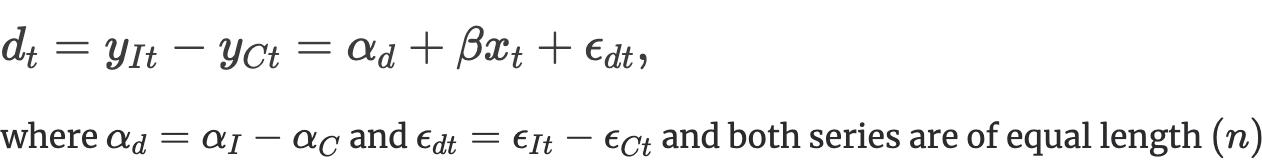

As a model, we run an OLS regression on the difference between thw rates, accounting for seasonality and autocorrlation as before.

In [ ]:
clicks_ts_spread <- clicks_ts_spread %>%
    mutate(ctr = visitors_that_clicked_rl/visitors*10^5)

In [ ]:
ctr_ts_spread <- clicks_ts_spread %>%
    select(date, Time, Intervention, TimeSince, time_series, ctr) %>%
    spread(time_series, ctr)

In [ ]:
head(ctr_ts_spread)

In [ ]:
ctr_ts_spread$ctr_diff <- with(ctr_ts_spread, intervention-control)

In [ ]:
head(ctr_ts_spread)

In [ ]:
plot(ctr_ts_spread$ctr_diff, 
      bty="n",
      col = gray(0.3,0.5), pch=19,
      #ylim = c(0, 0.04), 
      xlim = c(0,72),
      main = "Difference in Rate of visitors who clicked on at least 1 related link (per 10000 visitors)",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Difference in Rate of visitors (per 10,000)")
mtext(side = 3, line = 0.25, at = 1, adj = -2, "between intervention and control")

# Line marking the interruption
abline( v=42, col="firebrick",lwd = 2, lty=2 )
text( 42, 350, "Start of weighted related links", col="firebrick", cex=1.3, pos=4 )


In [ ]:
reg_ctr_diff <- lm( ctr_diff ~ Time + Intervention + TimeSince +
                tsModel::harmonic(ctr_ts_spread$date,2,7), 
                    data=ctr_ts_spread)


In [ ]:
summary(reg_ctr_diff)

In [ ]:
plot(acf(resid(reg_ctr_diff)))

In [ ]:
# robust standrad error
coeftest(reg_ctr_diff, vcov = NeweyWest(reg_ctr_diff, verbose=TRUE))

In [ ]:
coefci(reg_ctr_diff, vcov = NeweyWest(reg_ctr_diff, verbose=TRUE))

In [ ]:
diff_pred1 <- predict(reg_ctr_diff, ctr_ts_spread) 
# To estimate all predicted values of Y, we just use our dataset

diff_datanew <- as.data.frame(cbind(Time = rep(1 : length(ctr_ts_spread$Time)), 
                                    Intervention = 0, 
                                    TimeSince = 0)) 
# Create a new dataset where Treatment and Time Since Treatment are equal to 0 as the intervention did not occur.
diff_pred2 <- predict(reg_ctr_diff, diff_datanew)
# Predict the counterfactuals

plot(ctr_ts_spread$ctr_diff, 
      bty="n",
      col = gray(0.3,0.5), pch=19,
      #ylim = c(0, 0.04), 
      xlim = c(0,72),
      main = "Difference in Rate of visitors who clicked on at least 1 related link (per 100,000 visitors)",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Difference in Rate of visitors (per 100,000)")
mtext(side = 3, line = 0.25, at = 1, adj = -1.6, "between intervention and control")

# cunterfactual
lines( 1:(n_points_before), diff_pred1[1:(n_points_before)], col="dodgerblue4", lwd = 3 )
lines( (n_points_before):70, diff_pred1[(n_points_before):70], col="dodgerblue4", lwd = 3 )
# predicted line
lines( (n_points_before+1):70, diff_pred2[(n_points_before+1):70], col="darkorange2", lwd = 3, lty = 5 ) 

text(45, 430, labels = "Predicted values", pos = 4, cex = 1.3, col = "dodgerblue3")
text(50, 1100, labels = "Counterfactual", pos = 4, cex = 1.3, col = "darkorange2")

# Line marking the interruption
abline( v=(n_points_before+1), col="firebrick",lwd = 2, lty=2 )
text( (n_points_before+1), 350, "Start of weighted related links", col="firebrick", cex=1.3, pos=4 )


So after accounting for confounding variables via the controlled time series, we can see there is actually no effect whatsoever due to our intervention. Switching to the weighted related links did not affect nor improve the engagement of visitors with related links but it also did not make things worst. 

## Rate of repeated-clicker visitors

Let's do the same for our second evaluation metric: the rate of visitors that, having clicked on a related link, click on at least one more during the same day.

In [ ]:
unique(ts_long$metric)

In [ ]:
repeat_ts <- ts_long %>% filter(metric %in% c('visitors_that_clicked_rl', 'visitors_2_or_more_rl')) 

repeat_ts <- repeat_ts %>%
    group_by(time_series, metric) %>%
    mutate(Time = row_number()) %>%
    mutate(Intervention = ifelse(date <= as.Date("2021-11-20"), 0, 1))

In [ ]:
# check
table(repeat_ts[repeat_ts$metric == "visitors_2_or_more_rl",]$time_series)
table(repeat_ts[repeat_ts$metric == "visitors_that_clicked_rl",]$time_series)

In [ ]:
head(repeat_ts)

In [ ]:
# from long to wide
repeat_ts_spread <- repeat_ts %>%
    spread(metric, value)

In [ ]:
n_points_before <- as.numeric(table(repeat_ts_spread[repeat_ts_spread$time_series=="intervention",]$Intervention)["0"])
n_points_after <- as.numeric(table(repeat_ts_spread[repeat_ts_spread$time_series=="intervention",]$Intervention)["1"])

In [ ]:
repeat_ts_spread$TimeSince <- 0
repeat_ts_spread[repeat_ts_spread$time_series=="intervention",]$TimeSince <- c(rep(0, n_points_before), rep(1:n_points_after))
repeat_ts_spread[repeat_ts_spread$time_series=="control",]$TimeSince <- c(rep(0, n_points_before), rep(1:n_points_after))

In [ ]:
# Outcome variable as rate (per 1,000 visitors)
repeat_ts_spread$repeated_ctr <- with(repeat_ts_spread, visitors_2_or_more_rl/visitors_that_clicked_rl*10^3)

In [ ]:
head(repeat_ts_spread)

In [ ]:
repeat_ts_int <- repeat_ts_spread %>% filter(time_series=="intervention")

In [ ]:
# check
repeat_ts_int[38:44,]

### ITS analysis

We use the same approach and run an LSO on the rate values (per 10,000) (we can confirm with a quasipoisson as above later if needed), modelling seasonality with Fourier terms and autocorrelated errors with robust NeweyWest standard errors.

In [ ]:
plot(repeat_ts_int$repeated_ctr, 
      bty="n",
      col = gray(0.3,0.5), pch=19,
      xlim = c(0,72),
      main = "Rate of repeated-clicker visitors (per 1,000 visitors)",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Rate of repeated-clicker visitors (per 1,000)")
mtext(side = 3, line = 0.25, at = 1, adj = -1.6, "(node2vec related-link pages only)")


# Line marking the interruption
abline( v=n_points_before+1, col="firebrick",lwd = 2, lty=2 )
text( n_points_before+1, 175.5, "Start of weighted related links", col="firebrick", cex=1.3, pos=4 )


In [ ]:
reg_repeated <- lm( repeated_ctr ~ Time + Intervention + TimeSince +
                tsModel::harmonic(repeat_ts_int$date,2,7), 
                    data=repeat_ts_int)


In [ ]:
plot(acf(resid(reg_repeated)))

In [ ]:
# robust standrad error
coeftest(reg_repeated, vcov = NeweyWest(reg_repeated, verbose=TRUE))

In [ ]:
coefci(reg_repeated, vcov = NeweyWest(reg_repeated, verbose=TRUE))

No effect of our intervention (switch to related links), just a slight pre-intervention increase seemingly unaffacted by our intervention) 

In [ ]:
rep_pred1 <- predict(reg_repeated, repeat_ts_int) 
# To estimate all predicted values of Y, we just use our dataset

rep_datanew <- as.data.frame(cbind(
    Time = rep(1 : length(repeat_ts_int$Time)), 
    Intervention = 0, 
    TimeSince = 0)) 
# Create a new dataset where Treatment and Time Since Treatment are equal to 0 as the intervention did not occur.
rep_pred2 <- predict(reg_repeated, rep_datanew)
# Predict the counterfactuals

plot(repeat_ts_int$repeated_ctr, 
      bty="n",
      col = gray(0.3,0.5), pch=19,
      ylim = c(170, 250), 
      xlim = c(0,72),
      main = "Rate of repeated-clicker visitors (per 1,000 visitors)",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Rate of visitors (per 1,000)")
mtext(side = 3, line = 0.25, at = 1, adj = -1.6, "(node2vec related-link pages only)")

# cunterfactual
lines( 1:(n_points_before), rep_pred1[1:(n_points_before)], col="dodgerblue4", lwd = 3 )
lines( (n_points_before):70, rep_pred1[(n_points_before):70], col="dodgerblue4", lwd = 3 )
# predicted line
lines( (n_points_before+1):70, rep_pred2[(n_points_before+1):70], col="darkorange2", lwd = 3, lty = 5 ) 

text(43, 190, labels = "Predicted values", pos = 4, cex = 1.3, col = "dodgerblue3")
text(50, 230, labels = "Counterfactual", pos = 4, cex = 1.3, col = "darkorange2")

# Line marking the interruption
abline( v=n_points_before+1, col="firebrick",lwd = 2, lty=2 )
text( n_points_before+1, 170, "Start of weighted related links", col="firebrick", cex=1.3, pos=4 )


In [ ]:
head(repeat_ts_spread)

### Controlled time-series

In [ ]:
head(repeat_ts_spread)

In [ ]:
diff_repeat_ts <- repeat_ts_spread %>%
    select(date, time_series, Time, Intervention, TimeSince, repeated_ctr) %>%
    spread(time_series, repeated_ctr)

In [ ]:
head(diff_repeat_ts)

In [ ]:
diff_repeat_ts$repeat_diff <- with(diff_repeat_ts, intervention-control)

In [ ]:
head(diff_repeat_ts)

In [ ]:
plot(diff_repeat_ts$repeat_diff, 
      bty="n",
      col = gray(0.3,0.5), pch=19,
      #ylim = c(170, 250), 
      xlim = c(0,72),
      main = "Difference in rate of repeated-clicker visitors (per 1,000 visitors)",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Difference in rate of visitors (per 1,000)")
mtext(side = 3, line = 0.25, at = 1, adj = -1.6, "between Intervention and Control")


# Line marking the interruption
abline( v=n_points_before+1, col="firebrick",lwd = 2, lty=2 )
text( n_points_before+1, 29, "Start of weighted related links", col="firebrick", cex=1.3, pos=4 )


In [ ]:
reg_repeat_diff <- lm( repeat_diff ~ Time + Intervention + TimeSince +
                tsModel::harmonic(diff_repeat_ts$date,2,7), 
                    data=diff_repeat_ts)


In [ ]:
summary(reg_repeat_diff)

In [ ]:
plot(acf(resid(reg_repeat_diff)))

In [ ]:
# robust standrad error
coeftest(reg_repeat_diff, vcov = NeweyWest(reg_repeat_diff, verbose=TRUE))

In [ ]:
coefci(reg_repeat_diff, vcov = NeweyWest(reg_repeat_diff, verbose=TRUE))

In [ ]:
rep_diff_pred1 <- predict(reg_repeat_diff, diff_repeat_ts) 
# To estimate all predicted values of Y, we just use our dataset

rep_diff_datanew <- as.data.frame(cbind(
    Time = rep(1 : length(diff_repeat_ts$Time)), 
    Intervention = 0, 
    TimeSince = 0)) 
# Create a new dataset where Treatment and Time Since Treatment are equal to 0 as the intervention did not occur.
rep_diff_pred2 <- predict(reg_repeat_diff, rep_diff_datanew)
# Predict the counterfactuals

plot(diff_repeat_ts$repeat_diff, 
      bty="n",
      col = gray(0.3,0.5), pch=19,
      ylim = c(0, 70), 
      xlim = c(0,72),
      main = "Difference in rate of repeated-clicker visitors (per 1,000 visitors)",
      xlab = "Time elapsed since beginning of study (days)", 
      ylab = "Difference in rate of visitors (per 1,000)")
mtext(side = 3, line = 0.25, at = 1, adj = -1.6, "between Intervention and Control")

# cunterfactual
lines( 1:(n_points_before), rep_diff_pred1[1:(n_points_before)], col="dodgerblue4", lwd = 3 )
lines( (n_points_before):70, rep_diff_pred1[(n_points_before):70], col="dodgerblue4", lwd = 3 )
# predicted line
lines( (n_points_before+1):70, rep_diff_pred2[(n_points_before+1):70], col="darkorange2", lwd = 3, lty = 5 ) 

text(45, 38, labels = "Predicted values", pos = 4, cex = 1.3, col = "dodgerblue3")
text(50, 68, labels = "Counterfactual", pos = 4, cex = 1.3, col = "darkorange2")

# Line marking the interruption
abline( v=(n_points_before+1), col="firebrick",lwd = 2, lty=2 )
text( (n_points_before+1), 0, "Start of weighted related links", col="firebrick", cex=1.3, pos=4 )


Here again, even when accouting for possible confounding effects via the control time-series, no expected effect of our intervention on the time series of the evaluation metric.